In [1]:
from pathlib import Path
import numpy as np
from brainbox.processing import bincount2D
import matplotlib.pyplot as plt
from oneibl.one import ONE
import alf.io
import scipy.stats
import pandas as pd
import seaborn as sns
plt.ion()


def raster_complete(R, times, Clusters):
    '''
    Plot a rasterplot for the complete recording
    (might be slow, restrict R if so),
    ordered by insertion depth, with

    :param R: multidimensional binned neural activity
    :param times: ttl time stamps in sec
    :param Cluster: cluster ids
    '''

    plt.imshow(R, aspect='auto', cmap='binary', vmax=T_BIN / 0.001 / 4,
               origin='lower', extent=np.r_[times[[0, -1]], Clusters[[0, -1]]])

    plt.xlabel('Time (s)')
    plt.ylabel('Cluster #; ordered by depth')
    plt.show()

    # plt.savefig('/home/mic/Rasters/%s.png' %(trial_number))
    # plt.close('all')
    plt.tight_layout()


def _get_spike_counts_in_bins(spike_times, spike_clusters, intervals=None):
    """Return the number of spikes in a sequence of time intervals,
    for each neuron.
    :param spike_times: times of spikes, in seconds
    :type spike_times: 1D array
    :param spike_clusters: spike neurons
    :type spike_clusters: 1D array, same length as spike_times
    :type intervals: the times of the events onsets and offsets
    :param interval: 2D array
    :rtype: 2D array of shape `(n_neurons, n_intervals)`
    """
    # Check inputs.
    assert spike_times.ndim == spike_clusters.ndim == 1
    assert spike_times.shape == spike_clusters.shape
    intervals = np.atleast_2d(intervals)
    assert intervals.ndim == 2
    assert intervals.shape[1] == 2
    n_intervals = intervals.shape[0]

    # For each neuron and each interval, the number of spikes in the interval.
    neuron_ids = np.unique(spike_clusters)
    n_neurons = len(neuron_ids)
    counts = np.zeros((n_neurons, n_intervals), dtype=np.uint32)
    for j in range(n_intervals):
        t0, t1 = intervals[j, :]
        # Count the number of spikes in the window, for each neuron.
        x = np.bincount(
            spike_clusters[(t0 <= spike_times) & (spike_times < t1)],
            minlength=neuron_ids.max() + 1)
        counts[:, j] = x[neuron_ids]
    # value (i, j) is the number of spikes of neuron `neurons[i]` in interval
    # #j
    return counts


def are_neurons_responsive(
        spike_times,
        spike_clusters,
        stimulus_intervals=None,
        spontaneous_period=None,
        p_value_threshold=.05):
    """
    Return which neurons are responsive after
    specific stimulus events, compared to
    spontaneous activity, according to a Wilcoxon test.
    :param spike_times: times of spikes, in seconds
    :type spike_times: 1D array
    :param spike_clusters: spike neurons
    :type spike_clusters: 1D array, same length as spike_times
    :type stimulus_intervals: the times of
        the stimulus events onsets and offsets
    :param stimulus_intervals: 2D array
    :type spontaneous_period: the period of spontaneous activity
    :param spontaneous_period: 1D array with 2 elements
    :param p_value_threshold: the threshold for the
        p value in the Wilcoxon test.
    :type p_value_threshold: float
    :rtype: 1D boolean array with `n_neurons`
        elements (clusters are sorted by increasing cluster
        id as appearing in spike_clusters).
    """
    stimulus_counts = _get_spike_counts_in_bins(
        spike_times, spike_clusters, stimulus_intervals)
    # Find spontaneous intervals.
    stimulus_durations = np.diff(stimulus_intervals, axis=1).squeeze()
    t0, t1 = spontaneous_period
    spontaneous_starts = np.linspace(
        t0,
        t1 - stimulus_durations.max(),
        len(stimulus_intervals))
    spontaneous_intervals = np.c_[
        spontaneous_starts,
        spontaneous_starts +
        stimulus_durations]
    # Count the spontaneous counts.
    spontaneous_counts = _get_spike_counts_in_bins(
        spike_times, spike_clusters, spontaneous_intervals)
    assert stimulus_counts.shape == stimulus_counts.shape
    # Generate the responsive vector (for every neuron, whether it is
    # responsive).
    responsive = np.zeros(stimulus_counts.shape[0], dtype=np.bool)
    n_neurons = stimulus_counts.shape[0]
    for i in range(n_neurons):
        x = stimulus_counts[i, :]
        y = spontaneous_counts[i, :]
        try:
            _, p = scipy.stats.wilcoxon(x, y)
        except ValueError:
            pass
        responsive[i] = p < p_value_threshold
    return responsive


def compute_rfs(
        spike_times,
        spike_clusters,
        stimulus_times,
        stimulus,
        lags=8,
        binsize=0.025):
    """
    Compute receptive fields from locally sparse noise
    stimulus for all recorded neurons; uses a
    PSTH-like approach that averages responses
    from each neuron for each pixel flip
    :param spike_times: array of spike times
    :param spike_clusters: array of cluster ids associated
        with each entry of `spike_times`
    :param stimulus_times: (M,) array of stimulus presentation times
    :param stimulus: (M, y_pix, x_pix) array of pixel values
    :param lags: temporal dimension of receptive field
    :param binsize: length of each lag (seconds)
    :return: dictionary of "on" and "off"
        receptive fields (values are lists);
        each rf is [t, y_pix, x_pix]
    """

    from brainbox.processing import bincount2D

    cluster_ids = np.unique(spike_clusters)
    n_clusters = len(cluster_ids)
    _, y_pix, x_pix = stimulus.shape
    stimulus = stimulus.astype('float')
    subs = ['on', 'off']
    rfs = {
        sub: np.zeros(
            shape=(
                n_clusters,
                y_pix,
                x_pix,
                lags +
                1)) for sub in subs}
    flips = {sub: np.zeros(shape=(y_pix, x_pix)) for sub in subs}

    gray = np.median(stimulus)
    # loop over time points
    for i, t in enumerate(stimulus_times):
        # skip first frame since we're looking for pixels that flipped
        if i == 0:
            continue
        # find pixels that flipped
        frame_change = stimulus[i, :, :] - gray
        ys, xs = np.where((frame_change != 0) & (
            stimulus[i - 1, :, :] == gray))
        # loop over changed pixels
        for y, x in zip(ys, xs):
            if frame_change[y, x] > 0:  # gray -> white
                sub = 'on'
            else:  # black -> white
                sub = 'off'
            # bin spikes in the binsize*lags seconds following this flip
            t_beg = t
            t_end = t + binsize * lags
            idxs_t = (spike_times >= t_beg) & (spike_times < t_end)
            binned_spikes, _, cluster_idxs = bincount2D(
                spike_times[idxs_t], spike_clusters[idxs_t],
                xbin=binsize, xlim=[t_beg, t_end])
            # insert these binned spikes into the rfs
            _, cluster_idxs, _ = np.intersect1d(
                cluster_ids, cluster_idxs, return_indices=True)
            rfs[sub][cluster_idxs, y, x, :] += binned_spikes
            # record flip
            flips[sub][y, x] += 1

    # normalize spikes by number of flips
    for sub in rfs:
        for y in range(y_pix):
            for x in range(x_pix):
                if flips[sub][y, x] != 0:
                    rfs[sub][:, y, x, :] /= flips[sub][y, x]

    # turn into list
    rfs_list = {}
    for sub in subs:
        rfs_list[sub] = [rfs[sub][i, :, :, :] for i in range(n_clusters)]
    return rfs_list


def compute_rfs_corr(
        spike_times,
        spike_clusters,
        stimulus_times,
        stimulus,
        lags=8,
        binsize=0.025):
    """
    Compute receptive fields from locally
    sparse noise stimulus for all
    recorded neurons; uses a reverse correlation approach
    :param spike_times: array of spike times
    :param spike_clusters: array of cluster ids associated
        with each entry of `spikes`
    :param stimulus_times: (M,) array of stimulus presentation times
    :param stimulus: (M, y_pix, x_pix) array of pixel values
    :param lags: temporal dimension of receptive field
    :param binsize: length of each lag (seconds)
    :return: dictionary of "on" and "off" receptive
        fields (values are lists); each rf is [t, y_pix, x_pix]
    """

    from brainbox.processing import bincount2D
    from scipy.signal import correlate

    # bin spikes
    indx_t = (spike_times > np.min(stimulus_times)) & \
             (spike_times < np.max(stimulus_times))
    binned_spikes, ts_binned_spikes, cluster_ids = bincount2D(
        spike_times[indx_t], spike_clusters[indx_t], xbin=binsize)
    n_clusters = len(cluster_ids)

    _, y_pix, x_pix = stimulus.shape
    stimulus = stimulus.astype('float')
    gray = np.median(stimulus)

    subs = ['on', 'off']
    rfs = {
        sub: np.zeros(
            shape=(
                n_clusters,
                y_pix,
                x_pix,
                lags +
                1)) for sub in subs}

    # for indexing output of convolution
    i_end = binned_spikes.shape[1]
    i_beg = i_end - lags

    for sub in subs:
        for y in range(y_pix):
            for x in range(x_pix):
                # find times that pixels flipped
                diffs = np.concatenate([np.diff(stimulus[:, y, x]), [0]])
                if sub == 'on':  # gray -> white
                    changes = (diffs > 0) & (stimulus[:, y, x] == gray)
                else:
                    changes = (diffs < 0) & (stimulus[:, y, x] == gray)
                t_change = np.where(changes)[0]

                # put on same timescale as neural activity
                binned_stim = np.zeros(shape=ts_binned_spikes.shape)
                for t in t_change:
                    stim_time = stimulus_times[t]
                    # find nearest time in binned spikes
                    idx = np.argmin((ts_binned_spikes - stim_time) ** 2)
                    binned_stim[idx] = 1

                for n in range(n_clusters):
                    # cross correlate signal with spiking activity
                    # NOTE: scipy's correlate function is appx two orders of
                    # magnitude faster than numpy's correlate function on
                    # relevant data size; perhaps scipy uses FFT? Not in docs.
                    cc = correlate(
                        binned_stim, binned_spikes[n, :], mode='full')
                    rfs[sub][n, y, x, :] = cc[i_beg:i_end + 1]

    # turn into list
    rfs_list = {}
    for sub in subs:
        rfs_list[sub] = [rfs[sub][i, :, :, :] for i in range(n_clusters)]
    return rfs_list


def find_peak_responses(rfs):
    """
    Find peak response across time, space, and receptive field type ("on" and
    "off")
    :param rfs: dictionary of receptive fields (output of `compute_rfs`); each
        rf is of size [t, y_pix, y_pix]
    :return: dictionary containing peak rf time slice for both "on" and "off"
        rfs (values are lists)
    """
    rfs_peak = {key: [] for key in rfs.keys()}
    # loop over rf type
    for sub_type, subs in rfs.items():
        # loop over clusters
        for sub in subs:
            # max over space for each time point
            s_max = np.max(sub, axis=(0, 1))
            # take time point with largest max
            rfs_peak[sub_type].append(sub[:, :, np.argmax(s_max)])
    return rfs_peak


def interpolate_rfs(rfs, bin_scale):
    """
    Bilinear interpolation of receptive fields
    :param rfs: dictionary of receptive fields
        (single time slice)
    :param bin_scale: scaling factor to determine
        number of bins for interpolation;
        e.g. bin_scale=0.5 doubles the number of bins in both directions
    :return: dictionary of interpolated receptive fields (values are lists)
    """
    from scipy.interpolate import interp2d
    rfs_interp = {'on': [], 'off': []}
    x_pix, y_pix = rfs['on'][0].shape
    x_grid = np.arange(x_pix)
    y_grid = np.arange(y_pix)
    x_grid_new = np.arange(-0.5, x_pix, bin_scale)
    y_grid_new = np.arange(-0.5, y_pix, bin_scale)
    # loop over rf type
    for sub_type, subs in rfs.items():
        # loop over clusters
        for sub in subs:
            f = interp2d(y_grid, x_grid, sub)
            rfs_interp[sub_type].append(f(y_grid_new, x_grid_new))
    return rfs_interp


def extract_blob(array, y, x):
    """
    Extract contiguous blob of `True` values in a boolean array starting at the
    point (y, x)
    :param array: 2D boolean array
    :param y: initial y pixel
    :param x: initial x pixel
    :return: list of blob indices
    """
    y_pix, x_pix = array.shape
    blob = []
    pixels_to_check = [[y, x]]
    while len(pixels_to_check) != 0:
        pixel = pixels_to_check.pop(0)
        blob.append(pixel)
        y = pixel[0]
        x = pixel[1]
        # check N, S, E, W
        for idx in [[y - 1, x], [y + 1, x], [y, x + 1], [y, x - 1]]:
            if idx in blob:
                continue
            # check boundaries
            xi = idx[0]
            yi = idx[1]
            if (0 <= yi < y_pix) and (0 <= xi < x_pix):
                if array[xi, yi] and idx not in pixels_to_check:
                    pixels_to_check.append(idx)
    return blob


def extract_blobs(array):
    """
    Extract contiguous blobs of `True` values in a boolean array
    :param array: 2D boolean array
    :return: list of lists of blob indices
    """
    y_pix, x_pix = array.shape
    processed_pix = []
    blobs = []
    for y in range(y_pix):
        for x in range(x_pix):
            # find a blob starting at this point
            if not array[y, x]:
                continue
            if [y, x] in processed_pix:
                continue
            blob = extract_blob(array, y, x)
            for pixel in blob:
                processed_pix.append(pixel)
            blobs.append(blob)
    return blobs


def find_contiguous_pixels(rfs, threshold=0.35):
    """
    Calculate number of contiguous pixels in a thresholded version of the
    receptive field
    :param rfs: dictionary of receptive fields (single time slice)
    :param threshold: pixels below this fraction of the maximum firing are set
        to zero before contiguous pixels are calculated
    :return: dictionary of contiguous pixels for each rf type ("on and "off")
    """

    # store results
    n_clusters = len(rfs['on'])
    max_fr = np.zeros(n_clusters)
    contig_pixels = {'on': np.zeros(n_clusters), 'off': np.zeros(n_clusters)}

    # compute max firing rate for each cluster
    for sub_type, subs in rfs.items():
        for n, sub in enumerate(subs):
            max_fr[n] = np.max([max_fr[n], np.max(sub)])

    # compute max number of contiguous pixels
    for sub_type, subs in rfs.items():
        for n, sub in enumerate(subs):
            # compute rf mask using threshold
            rf_mask = sub > (threshold * max_fr[n])
            # extract contiguous pixels (blobs)
            blobs = extract_blobs(rf_mask)
            # save size of largest blob
            if len(blobs) != 0:
                contig_pixels[sub_type][n] = np.max(
                    [len(blob) for blob in blobs])

    return contig_pixels


def compute_rf_areas(rfs, bin_scale=0.5, threshold=0.35):
    """
    Compute receptive field areas as described in:
    Durand et al. 2016
    "A Comparison of Visual Response Properties 
    in the Lateral Geniculate Nucleus
    and Primary Visual Cortex of Awake and Anesthetized Mice"
    :param rfs: dictionary of receptive fields (dict keys are 'on' and 'off');
        output of `compute_rfs`
    :param bin_scale: scaling for interpolation (e.g. 0.5 doubles bins)
    :param threshold: pixels below this fraction of the maximum firing are set
        to zero before contiguous pixels are calculated
    :return: dictionary of receptive field areas for each type ("on" and "off")
    """

    # "the larger of the ON and OFF peak responses was taken to be the maximum
    # firing rate of the cluster"
    peaks = find_peak_responses(rfs)

    # "the trial-averaged mean firing rates within the peak bins were then used
    # to estimate the sizes of the ON and OFF subfields...we interpolated each
    # subfield using a 2D bilinear interpolation."
    peaks_interp = interpolate_rfs(peaks, bin_scale=bin_scale)

    # "All pixels in the interpolated grids that were <35% of the cluster's
    # maximum firing rate were set to zero and a contiguous non-zero set of
    # pixels, including the peak pixel, were isolated"
    contig_pixels = find_contiguous_pixels(peaks_interp, threshold=threshold)

    return contig_pixels


def plot_rf_distributions(rf_areas, plot_type='box'):
    """
    :param rf_areas:
    :param plot_type: 'box' | 'hist'
    :return: figure handle
    """

    # put results into dataframe for easier plotting
    results = []
    for sub_type, areas in rf_areas.items():
        for i, area in enumerate(areas):
            results.append(pd.DataFrame({
                'cluster_id': i,
                'area': area,
                'Subfield': sub_type.upper()}, index=[0]))
    results_pd = pd.concat(results, ignore_index=True)
    # leave out non-responsive clusters
    data_queried = results_pd[results_pd.area != 0]

    if plot_type == 'box':

        splt = sns.catplot(
            x='Subfield', y='area', kind='box', data=data_queried)
        splt.fig.axes[0].set_yscale('log')
        splt.fig.axes[0].set_ylabel('RF Area (pixels$^2$)')
        splt.fig.axes[0].set_ylim([1e-1, 1e4])

    elif plot_type == 'hist':
        bins = 10 ** (np.arange(-1, 4.25, 0.25))
        xmin = 1e-1
        xmax = 1e4
        ymin = 1e0
        ymax = 1e3
        splt = plt.figure(figsize=(12, 4))

        plt.subplot(121)
        plt.hist(data_queried[data_queried.Subfield ==
                              'ON']['area'], bins=bins, log=True)
        plt.xlabel('RF Area (pixels)')
        plt.xscale('log')
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
        plt.ylabel('Cluster count')
        plt.title('ON Subfield')

        plt.subplot(122)
        plt.hist(data_queried[data_queried.Subfield ==
                              'OFF']['area'], bins=bins, log=True)
        plt.xlabel('RF Area (pixels)')
        plt.xscale('log')
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
        plt.title('OFF Subfield')

    plt.show()

    return splt


In [2]:
    # get the data from flatiron and the current folder 
    one = ONE()
    eid = one.search(subject='ZM_2104', date='2019-09-19', number=1)
    D = one.load(eid[0], clobber=False, download_only=True)
    alf_path = Path(D.local_path[0]).parent

    session_path = alf_path
    path = alf_path
    odsgratings = np.load(path / '_iblcertif_.odsgratings.times.00.npy')
    spontaneous = np.load(path / '_iblcertif_.spontaneous.times.00.npy')
    spike_times = np.load(path / 'spikes.times.npy')
    spike_clusters = np.load(path / 'spikes.clusters.npy')

Connected to https://alyx.internationalbrainlab.org as michael.schartner


2019-11-11 14:36:02.597 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/channels.rawInd.c522b2c7-4240-443d-9733-00683873ec41.npy Bytes: 2632


2019-11-11 14:36:03.0 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/clusters.depths.e4a2ec70-a263-4a14-9719-84e1cef98ecb.npy Bytes: 5880


2019-11-11 14:36:03.412 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/clusters.channels.19c7397f-323c-4cae-8281-f8f3d275f409.npy Bytes: 5880


2019-11-11 14:36:03.837 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/spikes.templates.ef34d68f-d0e9-4b77-b8fe-d95c0c7739ac.npy Bytes: 72676584


2019-11-11 14:36:07.135 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/spikes.samples.c15521cc-0edb-4a7c-a109-672c72d97014.npy Bytes: 145353040


2019-11-11 14:36:12.655 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/spikes.times.e8fb56cb-3d78-43ed-92d6-dfe0c9e9e61a.npy Bytes: 145353040


2019-11-11 14:36:18.155 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/spikes.depths.d85dfd4b-7d3c-4164-8a93-7b19b1fb0b20.npy Bytes: 145353040


2019-11-11 14:36:29.713 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/spikes.amps.77196013-71d3-485f-85a1-4887d89e38e5.npy Bytes: 145353040


2019-11-11 14:36:36.757 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/spikes.clusters.60d1268b-8331-4e89-ac77-e75c5d17e2c0.npy Bytes: 72676584


2019-11-11 14:36:41.991 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/clusters.peakToTrough.2a3c1064-ae22-489c-99eb-c088c09983f2.npy Bytes: 5880


2019-11-11 14:36:42.407 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/clusters.amps.62d41868-aea2-41dd-b9bf-e58e2aa1e7f4.npy Bytes: 5880


2019-11-11 14:36:42.799 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/channels.localCoordinates.c3df3f84-2fa0-4cc4-afa6-3beb800d5837.npy Bytes: 5088


2019-11-11 14:36:43.187 INFO     [webclient.py:81] Downloading: /home/mic/Downloads/FlatIron/mainenlab/Subjects/ZM_2104/2019-09-19/001/alf/channels._phy_ids.ae825a00-e4d1-412c-9835-07e12e17a850.npy Bytes: 1380


In [3]:
# Return which neurons are responsive after specific stimulus events, 
# compared to spontaneous activity, according to a Wilcoxon test. 

In [4]:
    resp = are_neurons_responsive(
        spike_times,
        spike_clusters,
        odsgratings,
        spontaneous)
    

/home/mic/miniconda3/envs/iblenv/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [5]:
print(resp.size)



704


In [6]:
# There are 704 clusters in this recording (double probe) 

In [7]:
print(resp)


[ True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [8]:
print("Fraction of responsive neurons: ", resp.mean())

Fraction of responsive neurons:  0.9715909090909091


In [9]:
# Create a raster plot with time-binned activity of all units ordered by cluster-depth


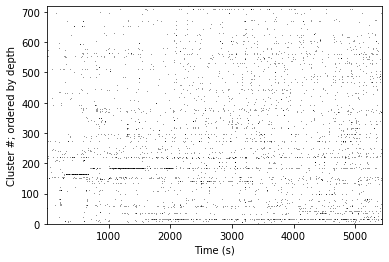

<Figure size 432x288 with 0 Axes>

In [10]:
    spikes = alf.io.load_object(alf_path, 'spikes')

    # bin activity
    print
    T_BIN = 0.01  # [sec]
    R, times, Clusters = bincount2D(spikes['times'], spikes['clusters'], T_BIN)

    # Order activity by anatomical depth of neurons
    d = dict(zip(spikes['clusters'], spikes['depths']))
    y = sorted([[i, d[i]] for i in d])
    isort = np.argsort([x[1] for x in y])
    R = R[isort, :]

    # get a raster plot for the complete recording
    raster_complete(R, times, Clusters)

computing receptive fields...done
computing receptive field areas...done


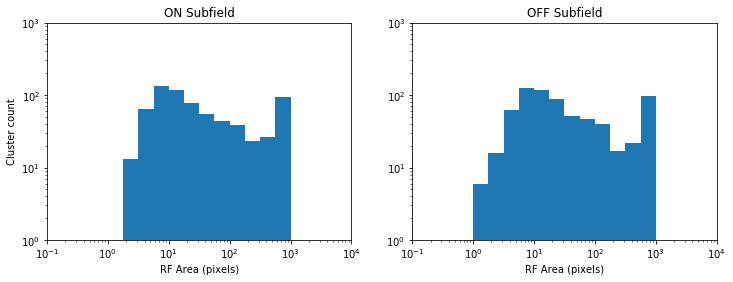

In [11]:
    # Matt's receptive field analysis (plot_rf_distributions(rf_areas, plot_type='hist'))

    # user options
    BINSIZE = 0.05  # sec
    LAGS = 4  # number of bins for calculating RF
    METHOD = 'corr'  # 'corr' | 'sta'

    # load objects
    spikes = alf.io.load_object(session_path, 'spikes')
    rfmap = alf.io.load_object(session_path, '_iblcertif_.rfmap')
    rf_stim_times = rfmap['rfmap.times.00']
    rf_stim = rfmap['rfmap.stims.00'].astype('float')

    # compute receptive fields
    if METHOD == 'sta':
        # method in Durand et al 2016; ~9 min for 700 units on a single cpu
        # core
        print('computing receptive fields...', end='')
        rfs = compute_rfs(
            spikes.times,
            spikes.clusters,
            rf_stim_times,
            rf_stim,
            lags=LAGS,
            binsize=BINSIZE)
        print('done')
    elif METHOD == 'corr':
        # reverse correlation method; ~3 min for 700 units on a single cpu core
        print('computing receptive fields...', end='')
        rfs = compute_rfs_corr(
            spikes.times,
            spikes.clusters,
            rf_stim_times,
            rf_stim,
            lags=LAGS,
            binsize=BINSIZE)
        print('done')
    else:
        raise NotImplementedError(
            'The %s method to compute rfs is not implemented' %
            METHOD)

    print('computing receptive field areas...', end='')
    rf_areas = compute_rf_areas(rfs)
    print('done')

    fig = plot_rf_distributions(rf_areas, plot_type='hist')